# Meta-labelling

## Objetivos

- Revisar algunos algortimos de Advances in Financial Machine Learning. Capítulos 2, 3 (y algo del 20).
- Tópicos de Labelling.


## Bibliografia

- Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley

## Recursos

- Python 3.7+
- Jupyter notebook.
- Pandas
- numpy
- matplotlib

## Descripcion

En la siguiente notebook vamos a seguir la linea de trabajo del capítulo 3 del libro.
A partir de un dataset descargado de Yahoo Finance del ETF [MTUM](https://www.ishares.com/us/products/251614/ishares-msci-usa-momentum-factor-etf) vamos a
generar labels de entrada y salida con el método de la triple frontera:

- Frontera de profit taking (frontera horizontal superior)
- Frontera de stop loss (frontera horizontal inferior)
- Frontera temporal (frontera vertical)

En el libro se discute brevemente que hacer cuando la señal no toca ninguna de las fronteras
horizontales y alcanza el span temporal. Lopez de Prado recomienda tomar el signo del retorno
en ese instante temporal, aquí se opta por la innacción, es decir, mantenemos la posición.

En esta notebook vamos a trabajar con una estrategia que nos permite evaluar los tamaños
de las apuestas mediante un algoritmo de ML, pero la decision de entrar y salir la vamos a
ejecutar con cruce de medias móviles de distinto ancho de ventana.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# %load mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [3]:
# %load labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [4]:
# %load events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

### 1.- Exploración del dataset

- Levantamos el datset desde un CSV
- Nota: indexamos el dataset con la columna de fechas para poder aprovechar las funciones del libro
  como estan dadas.
- Describimos el dataset.
- Mostramos la evolución de las series.


A saber, las columnas son:

- `Date`: es la fecha que aplica una estampa temporal a la fila.
- `Open`: es el precio en USD al que abre la cotización del fondo.
- `High`: es el mayor valor en USD que alcanza la cotización del fondo.
- `Low`: es el menor valor en USD que alcanza la cotización del fondo.
- `Close`: es el valor de cierre en USD que alcanza la cotización del fondo.
- `Adj Close`: es el precio ajustado que alcanzan algunos activos producto de multiplicadores por regalías y dividendos. Ver https://help.yahoo.com/kb/SLN28256.html para una descripción más detallada al respecto.
- `Volume`: cantidad total de USD operados.

In [5]:
MTUM_PATH = '../datasets/mtum.csv'

In [6]:
# Función que permite convertir el formato de las fechas como string
# en un objeto de fecha.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [7]:
mtum = pd.read_csv(MTUM_PATH, parse_dates=['Date'], date_parser=string_to_date, index_col='Date')

In [8]:
mtum.head() # Filas iniciales del dataset.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-18,50.919998,50.919998,50.919998,50.919998,46.707516,400
2013-04-19,50.919998,50.919998,50.919998,50.919998,46.707516,0
2013-04-22,50.919998,50.919998,50.919998,50.919998,46.707516,0
2013-04-23,52.220001,52.220001,52.220001,52.220001,47.899956,600
2013-04-24,51.700001,51.700001,51.560001,51.560001,47.294567,1100


In [9]:
mtum.tail() # Filas finales del dataset.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-09,143.300003,145.440002,142.380005,144.600006,144.600006,1681900
2020-09-10,146.000000,146.589996,141.339996,142.020004,142.020004,614100
2020-09-11,143.250000,143.539993,139.889999,141.529999,141.529999,616800
2020-09-14,143.339996,145.320007,143.070007,144.669998,144.669998,677400
2020-09-15,146.649994,147.419998,146.089996,146.979996,146.979996,561300


In [10]:
# [#Filas, #Columnas]
mtum.shape[0], mtum.shape[1]

(1867, 6)

In [11]:
# Tipo de dato de cada columna.
mtum.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

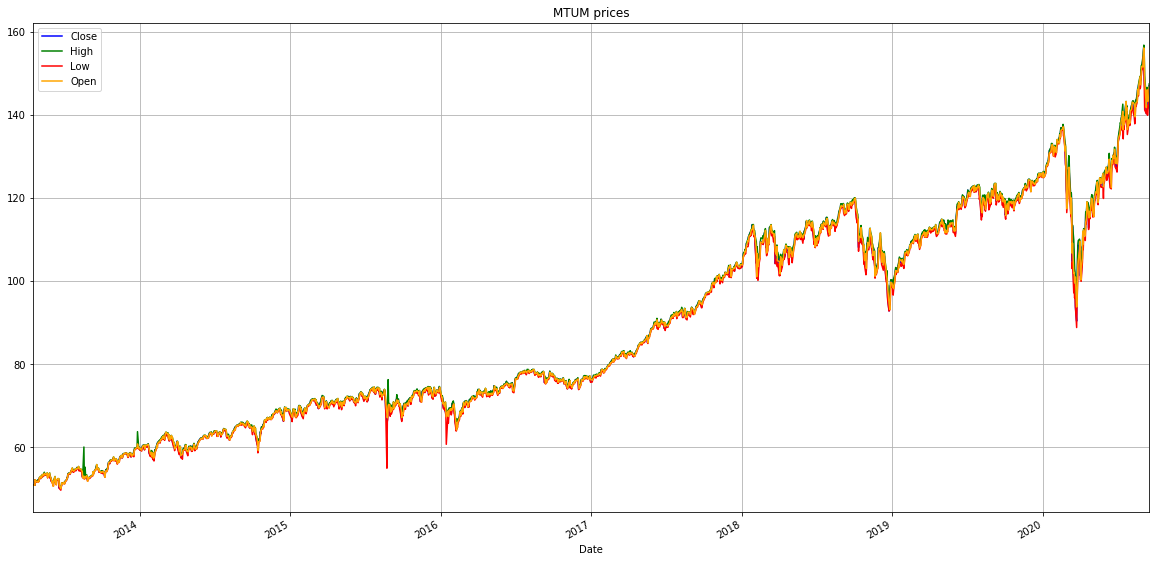

In [12]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Close', color='blue', ax=ax)
mtum.plot(kind='line',y='High', color='green', ax=ax)
mtum.plot(kind='line',y='Low', color='red', ax=ax)
mtum.plot(kind='line',y='Open', color='orange', ax=ax)
plt.title('MTUM prices')
plt.grid()
plt.show()

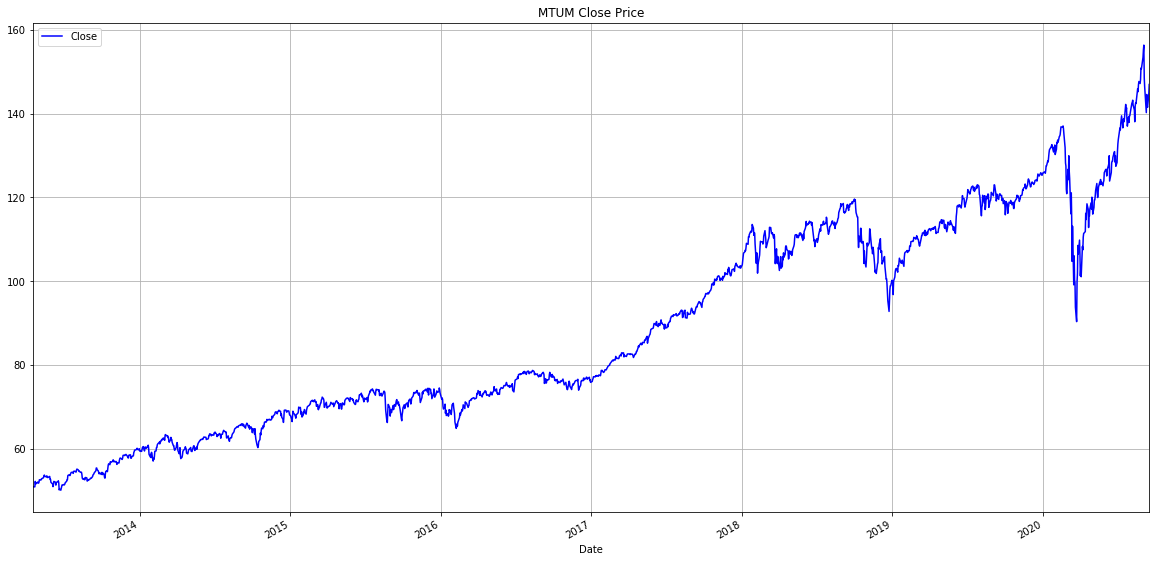

In [13]:
# En particular los va a interesar el precio de cierre.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Close', color='blue', ax=ax)
plt.title('MTUM Close Price')
plt.grid()
plt.show()

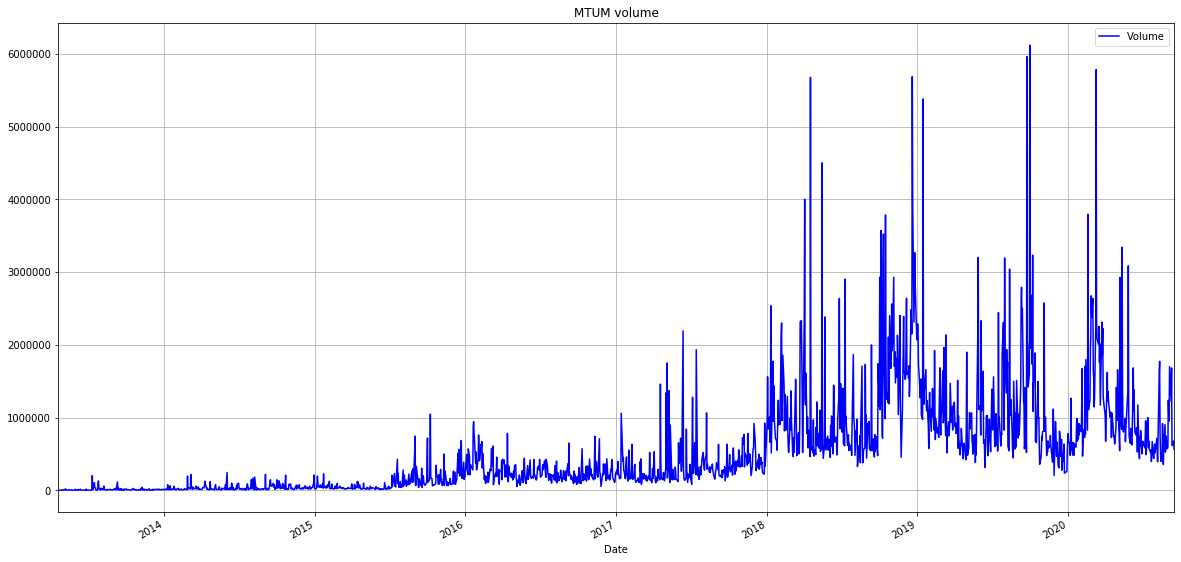

In [14]:
# Solo para comparar, miramos el volumen operado.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
mtum.plot(kind='line',y='Volume', color='blue', ax=ax)
plt.title('MTUM volume')
plt.grid()
plt.show()

### 2.- Desarrollo con labels

El procedimiento propuesto en el capítulo 3 del Lopez de Prado sugiere que a
partir de una estrategia donde conozcamos en qué momento comprar y vender nuestro
activo, generemos un modelo de ML que nos permita aprender el tamaño de la apuesta.
En lo que sigue vamos a usar el cruce de medias exponenciales como referencia de compra
y venta.

Cada una de las señales de compra y venta actúa como un disparador que posiciona
el inicio de la ventana de triple frontera. Debemos entonces generar una marca temporal
que indique cuando termina dicha ventana.

Una vez que tenemos los inicios de ventana (provistos por nuestra estrategia de trading)
y las terminaciones como frontera vertical (con un valor temporal a aprender, es un hiperparametro
de nuestra estrategia como lo son los retornos de entrada y salida!) debemos analizar
que sucede con la señal de precios para generar el label correcto. Esto implica entender
si la señal toca la barrera de profit taking, stop loss o la vertical primero.

Finalmente, generamos un data frame que nos indica en qué momento, con qué retorno
y que señal (entrada o salida). Esto será la información que le daremos a un algoritmo
de ML para que aprenda el tamaño de la apuesta.

In [15]:
# Computamos los eventos de cruce de media moviles (a optimizar!)
fast_window_num_days = 3
slow_window_num_days = 6
tEvents = getEwmEvents(mtum['Close'], fast_window_num_days, slow_window_num_days)
tEvents

Date
2013-05-30   -1
2013-07-05    1
2013-08-14   -1
2013-09-10    1
2013-10-03   -1
             ..
2019-10-22   -1
2019-10-25    1
2020-02-25   -1
2020-04-08    1
2020-09-08   -1
Length: 121, dtype: int64

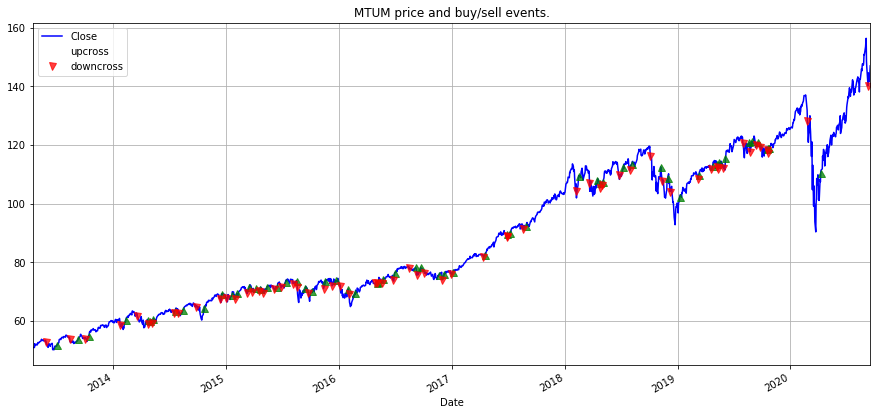

In [16]:
# Graficamos la serie de precios agregando unas flechas de color que indique
# el signo de la apuesta.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
mtum.plot(kind='line',y='Close', color='blue', ax=ax)
mtum.loc[tEvents[tEvents == 1].index].plot(
    ax=ax,ls='',marker='^', markersize=7, alpha=0.75, label='upcross', color='g', y='Close')
mtum.loc[tEvents[tEvents == -1].index].plot(
    ax=ax,ls='',marker='v', markersize=7, alpha=0.75, label='downcross', color='r', y='Close')
plt.title('MTUM price and buy/sell events.')
plt.grid()
plt.show()

In [17]:
# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

In [18]:
# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, mtum['Close'], numDays=num_days)
t1

Date
2013-05-30   2013-06-05
2013-07-05   2013-07-11
2013-08-14   2013-08-20
2013-09-10   2013-09-16
2013-10-03   2013-10-09
                ...    
2019-10-22   2019-10-28
2019-10-25   2019-10-31
2020-02-25   2020-03-02
2020-04-08   2020-04-14
2020-09-08   2020-09-14
Name: Date, Length: 121, dtype: datetime64[ns]

In [19]:
# Definimos las bandas de PT y SL.
ptSl = [0.015, 0.005]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=mtum['Close'], span0=50)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.01
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

In [20]:
# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(mtum['Close'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
triple_barrier_events

2020-11-12 21:02:35.851679 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


,t1,trgt,side
Date,,,
2013-07-05,2013-07-08,0.012620,1.0
2013-10-14,2013-10-15,0.011511,1.0
2014-01-24,2014-01-27,0.011497,-1.0
2014-02-11,2014-02-12,0.013220,1.0
2014-03-21,2014-03-24,0.011509,-1.0
...,...,...,...
2019-10-22,2019-10-23,0.012102,-1.0
2019-10-25,2019-10-28,0.012189,1.0
2020-02-25,2020-02-26,0.014213,-1.0


In [21]:
# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, mtum['Close'])
labels

,ret,bin
Date,,
2013-07-05,0.005583,1.0
2013-10-14,-0.003835,0.0
2014-01-24,0.010227,1.0
2014-02-11,0.000498,1.0
2014-03-21,0.013483,1.0
...,...,...
2019-10-22,0.000511,1.0
2019-10-25,0.004705,1.0
2020-02-25,0.005848,1.0


In [22]:
# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
labels['bin'].value_counts()

1.0    39
0.0    37
Name: bin, dtype: int64

In [23]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [24]:
# Preparamos la informacion para introducirla en un modelo de ML.
X = triple_barrier_events.dropna().side.values.reshape(-1,1)
y = labels.bin.values
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [25]:
# Hiperpametros
n_estimator = 100     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [26]:
# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.67      0.63      0.65        19
         1.0       0.65      0.68      0.67        19

    accuracy                           0.66        38
   macro avg       0.66      0.66      0.66        38
weighted avg       0.66      0.66      0.66        38



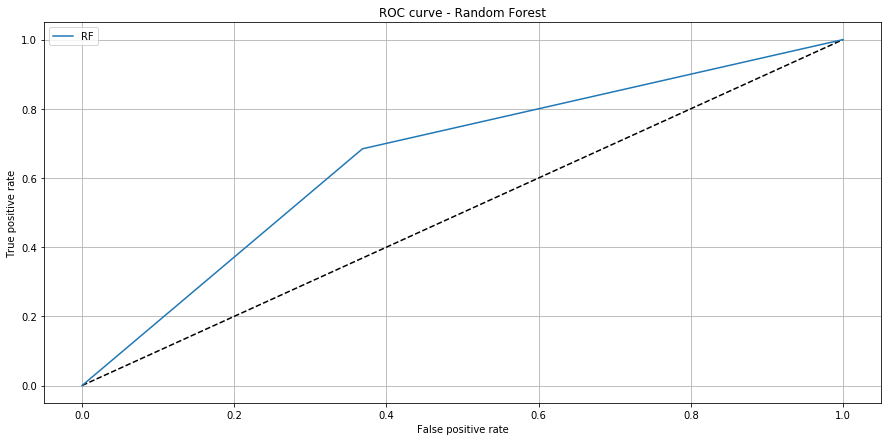

In [27]:
# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print(classification_report(y_test, y_pred_rf))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()

In [28]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 100     # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=0.5, n_estimators=100, n_jobs=4,
                  oob_score=False, random_state=123, verbose=0,
                  warm_start=False)

In [29]:
# Predecimos con el test set y contrastamos.
y_pred_bc_prob = rf.predict_proba(X_test)[:, 1]
y_pred_bc = rf.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.67      0.63      0.65        19
         1.0       0.65      0.68      0.67        19

    accuracy                           0.66        38
   macro avg       0.66      0.66      0.66        38
weighted avg       0.66      0.66      0.66        38



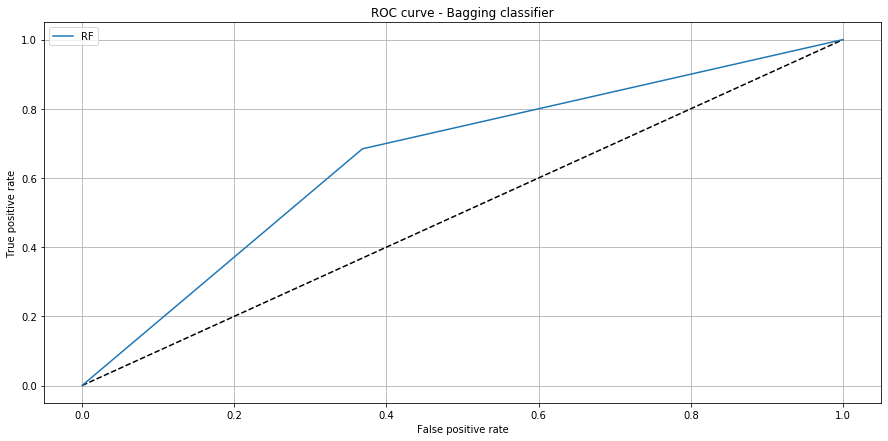

In [30]:
# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_prob)
print(classification_report(y_test, y_pred_bc))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier')
plt.legend(loc='best')
plt.grid()
plt.show()